In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### 파일 불러오기 

In [3]:
# 1. 파일 불러오기
sal_data_24 = pd.read_csv('2024_연봉_statiz.csv')
sal_data_24

,선수,연봉(만원),WAR,WAR당 연봉,팀,pid
0,류현진,250000,4.56,54775,한화 이글스,10590
1,채은성,100000,1.40,71340,한화 이글스,11215
2,페냐,65000,0.35,187034,한화 이글스,15146
3,페라자,60000,2.90,20686,한화 이글스,16121
4,최재훈,60000,1.68,35760,한화 이글스,10170
...,...,...,...,...,...,...
850,박준형,3000,-0.25,-12108,키움 히어로즈,14211
851,박윤성,3000,0.04,72014,키움 히어로즈,15475
852,서유신,3000,-,-,키움 히어로즈,15483
853,이명기,3000,-,-,키움 히어로즈,14212


In [4]:
# 팀별/전체 연봉순위 파생변수 생성
df = sal_data_24.copy()
df['연봉'] = df['연봉(만원)']

# 팀별 연봉순위 (1등 = 가장 연봉 높은 선수)
df['팀연봉순위'] = df.groupby('팀')['연봉'].rank(ascending=False, method='first')
# 전체 연봉순위
df['전체연봉순위'] = df['연봉'].rank(ascending=False, method='first')

In [5]:
#1. FA 공식 등급제
def get_fa_grade(row):
    if row['팀연봉순위'] <= 3 or row['전체연봉순위'] <= 30:
        return 'A'
    elif 4 <= row['팀연봉순위'] <= 10 or 31 <= row['전체연봉순위'] <= 60:
        return 'B'
    else:
        return 'C'

df['등급_FA'] = df.apply(get_fa_grade, axis=1)

In [6]:
# 2. 팀 내 연봉 순위 기준
def team_rank_grade(rank):
    if rank <= 3:
        return 'A'
    elif 4 <= rank <= 10:
        return 'B'
    else:
        return 'C'

df['등급_팀내순위'] = df['팀연봉순위'].apply(team_rank_grade)

In [7]:
df['연봉'] = pd.to_numeric(df['연봉'], errors='coerce')
print(df['연봉'].isna().sum())
# 만약 이때 NaN이 생기면, 원래 문자열로 되어있던 이상치(예: '정보없음' 등)가 있던 것!

5


In [8]:
# 3. 분위수(Quantile) - 차등 분배
# 데이터 타입 int 변경 및 결측치 거거
df['연봉'] = pd.to_numeric(df['연봉'], errors='coerce')
valid_salary = df['연봉'].dropna()

# A: 상위 1%, B: 1~10%, C: 10~30%, D: 30~60%, E: 하위 40%
percentiles = [0, 0.40, 0.70, 0.90, 0.99, 1.0]
quantiles = [np.percentile(valid_salary, 100*p) for p in percentiles]

labels = ['E', 'D', 'C', 'B', 'A']
df['등급_차등분위'] = pd.cut(df['연봉'], bins=quantiles, labels=labels, include_lowest=True)

- E: 0 ~ 3,000 (최하위, 하위 25% 기준)
- D: 3,001 ~ 3,600 (중하위, 중앙값까지)
- C: 3,601 ~ 9,875 (중위권, 3사분위수까지)
- B: 9,876 ~ 13,214 (평균 미만)
- A: 13,215 ~ 250,000 (평균 이상~최고)

In [10]:
#4. (평균/표준편차 기반 5단계)
bins = [0, 3000, 3600, 9875, 13214, 250000]
labels = ['E', 'D', 'C', 'B', 'A']
df['등급_직접설정'] = pd.cut(df['연봉'], bins=bins, labels=labels, include_lowest=True)

- A+: 50,000(5억) 이상 (슈퍼스타)
- A: 13,215 ~ 49,999 (상위권, 평균 이상)
- B: 9,876 ~ 13,214 (중상위)
- C: 3,601 ~ 9,875 (중위권)
- D: 3,001 ~ 3,600 (중하위)
- E: 0 ~ 3,000 (최하위)

In [12]:
# 5.슈퍼스타 구간 분리 6단계)
bins = [0, 3000, 3600, 9875, 13214, 50000, 250000]
labels = ['E', 'D', 'C', 'B', 'A', 'A+']
df['등급_슈퍼스타'] = pd.cut(df['연봉'], bins=bins, labels=labels, include_lowest=True)

In [19]:
#6. 혼합 구간 분리
# '-'(문자), None 등을 먼저 NaN으로
df['연봉'] = df['연봉'].replace('-', np.nan)

# 숫자형(실수)으로 변환, 변환 안되는 값은 NaN
df['연봉'] = pd.to_numeric(df['연봉'], errors='coerce')

# NaN 아닌 값만으로 분위수 계산
q5 = np.percentile(df['연봉'].dropna(), 95)
q10 = np.percentile(df['연봉'].dropna(), 90)
q20 = np.percentile(df['연봉'].dropna(), 80)

def hybrid_grade(row, q5, q10, q20):
    # A+ 등급: 팀내 1~3위 또는 연봉 상위 5% (슈퍼스타)
    if row['팀연봉순위'] <= 3 or row['연봉'] >= q5:
        return 'A+'
    # A 등급: 팀내 4~10위 또는 연봉 상위 10%
    elif (4 <= row['팀연봉순위'] <= 10) or (q10 <= row['연봉'] < q5):
        return 'A'
    # B 등급: 연봉 상위 10~20%
    elif q20 <= row['연봉'] < q10:
        return 'B'
    # 나머지는 연봉 구간 직접설정 (C, D, E 등)
    elif row['연봉'] >= 9875:
        return 'C'
    elif row['연봉'] >= 3600:
        return 'D'
    else:
        return 'E'
        
df['등급_혼합'] = df.apply(lambda row: hybrid_grade(row, q5, q10, q20), axis=1)

In [16]:
print(df['연봉'].describe())
print(df['연봉'].head(10))

count       850.000000
mean      13214.117647
std       25206.711265
min        1500.000000
25%        3000.000000
50%        3600.000000
75%        9875.000000
max      250000.000000
Name: 연봉, dtype: float64
0    250000.0
1    100000.0
2     65000.0
3     60000.0
4     60000.0
5     50000.0
6     50000.0
7     50000.0
8     48000.0
9     35000.0
Name: 연봉, dtype: float64


In [25]:
# '연봉(만원)' 컬럼이 문자열/문자일 경우 숫자형으로 변환
df['연봉'] = pd.to_numeric(df['연봉(만원)'].replace('-', np.nan), errors='coerce')

# 원하는 분위 구간(0~100 사이 정수값, 인원 분포를 조절 가능)
percentiles = [0, 3, 10, 25, 50, 80, 100]

# 분위수 구간 경계값 구하기
quantiles = [np.percentile(df['연봉'].dropna(), p) for p in percentiles]

# 중복 구간 제거 (동일 값 있을 수 있으니)
quantiles = sorted(set(quantiles))

# labels 개수 = quantiles(구간) - 1
labels = ['E', 'D', 'C', 'B', 'A', 'A+'][:len(quantiles)-1]

df['등급_혼합'] = pd.cut(df['연봉'], bins=quantiles, labels=labels, include_lowest=True)

### 시각화(전체 분포)

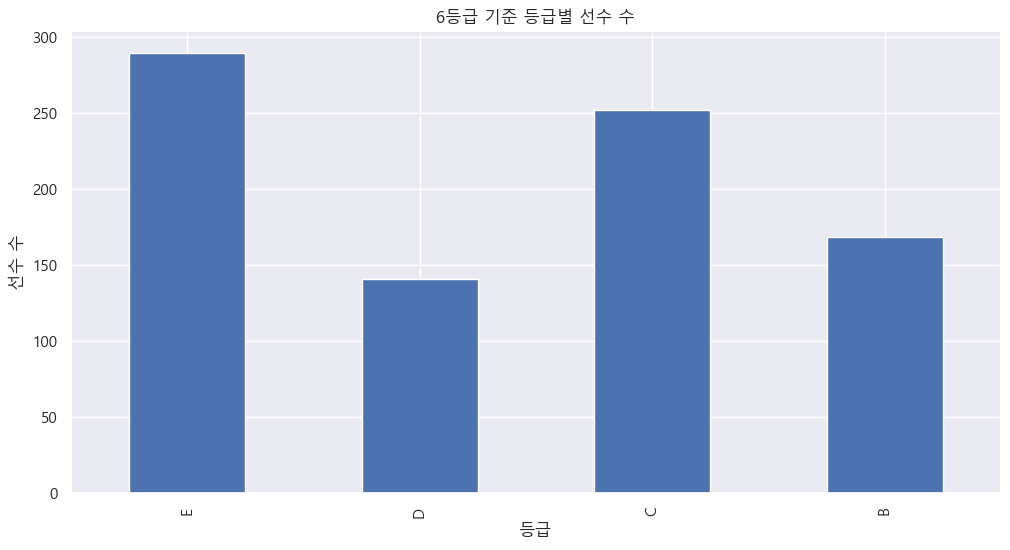

In [27]:
def plot_grade_dist(df, grade_col, title):
    df[grade_col].value_counts().sort_index().plot(kind='bar')
    plt.title(title)
    plt.xlabel('등급')
    plt.ylabel('선수 수')
    plt.show()

#plot_grade_dist(df, '등급_FA', 'KBO 공식 FA 등급제 등급별 선수 수')
#plot_grade_dist(df, '등급_분위수', '분위수 기준 등급별 선수 수')
#plot_grade_dist(df, '등급_팀내순위', '팀 내 연봉 순위 기준 등급별 선수 수')
#plot_grade_dist(df, '등급_차등분위', '차등 등급별 선수 수')
#plot_grade_dist(df, '등급_직접설정', '범위 설정 기준 등급별 선수 수')
#plot_grade_dist(df, '등급_슈퍼스타', '6등급 기준 등급별 선수 수')
plot_grade_dist(df, '등급_혼합', '6등급 기준 등급별 선수 수')

### 시각화 (구단별 분포)

In [ ]:
def plot_team_grade_dist(df, grade_col, title):
    ct = pd.crosstab(df['팀'], df[grade_col])
    ct.plot(kind='bar', stacked=True, figsize=(10,5))
    plt.title(title)
    plt.xlabel('구단')
    plt.ylabel('선수 수')
    plt.legend(title='등급')
    plt.show()

plot_team_grade_dist(df, '등급_FA', '구단별 KBO 공식 FA 등급제')
plot_team_grade_dist(df, '등급_분위수', '구단별 분위수 기준')
plot_team_grade_dist(df, '등급_팀내순위', '구단별 팀 내 연봉 순위 기준')

In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://statiz.sporki.com/season/?m=teamoverall&year=2024"
headers = {"User-Agent": "Mozilla/5.0"}
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

# 페이지 내 모든 테이블 불러오기
tables = pd.read_html(res.text)

rank_team = tables[1]
rank_team